### 주가 데이터를 RNN의 일종인 LSTM에 학습시켜 미래의 주가를 예측

In [70]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
from math import sqrt

import pandas_datareader.data as wb

## 1. Dataset Load
  yahoo finance로 부터 삼성전자의 주가 데이터를 불러옴


In [71]:
start = datetime(2010, 1, 1)
end = datetime(2019, 12, 31)

svalue = wb.DataReader('005930.KS', 'yahoo', start, end)
svalue.to_csv('./sample_data/samsung.csv')

samsung = pd.read_csv('./sample_data/samsung.csv')
samsung.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


,Date,High,Low,Open,Close,Volume,Adj Close
0,2010-01-04,16180.0,16000.0,16060.0,16180.0,11950800.0,5.854249
1,2010-01-05,16580.0,16300.0,16520.0,16440.0,27925850.0,5.948323
2,2010-01-06,16820.0,16520.0,16580.0,16820.0,22948850.0,6.085815
3,2010-01-07,16820.0,16260.0,16820.0,16260.0,22107950.0,5.883196
4,2010-01-08,16420.0,16120.0,16400.0,16420.0,14777550.0,5.941086


In [72]:
df = samsung.drop(samsung.columns[[5,6]], axis=1)
df = df.set_index(['Date'])
df.head()

,High,Low,Open,Close
Date,,,,
2010-01-04,16180.0,16000.0,16060.0,16180.0
2010-01-05,16580.0,16300.0,16520.0,16440.0
2010-01-06,16820.0,16520.0,16580.0,16820.0
2010-01-07,16820.0,16260.0,16820.0,16260.0
2010-01-08,16420.0,16120.0,16400.0,16420.0


In [73]:
df['High'] = df['High'] / 100000
df['Open'] = df['Open'] / 100000
df['Low'] = df['Low'] / 100000
df['Close'] = df['Close'] / 100000
print(df.head())
print(df.tail())

              High     Low    Open   Close
Date                                      
2010-01-04  0.1618  0.1600  0.1606  0.1618
2010-01-05  0.1658  0.1630  0.1652  0.1644
2010-01-06  0.1682  0.1652  0.1658  0.1682
2010-01-07  0.1682  0.1626  0.1682  0.1626
2010-01-08  0.1642  0.1612  0.1640  0.1642
             High    Low   Open  Close
Date                                  
2019-12-23  0.564  0.551  0.561  0.555
2019-12-24  0.557  0.548  0.556  0.550
2019-12-26  0.554  0.544  0.547  0.554
2019-12-27  0.569  0.555  0.557  0.565
2019-12-30  0.566  0.557  0.562  0.558


In [74]:
data = df.values.reshape(df.shape[0],4)
data

array([[0.1618, 0.16  , 0.1606, 0.1618],
       [0.1658, 0.163 , 0.1652, 0.1644],
       [0.1682, 0.1652, 0.1658, 0.1682],
       ...,
       [0.554 , 0.544 , 0.547 , 0.554 ],
       [0.569 , 0.555 , 0.557 , 0.565 ],
       [0.566 , 0.557 , 0.562 , 0.558 ]])

train-test 셋을 0.8:0.2 비율로 나눔

In [75]:
result = []
sequence_length = 6
for index in range(len(data) - sequence_length):
    result.append(data[index: index + sequence_length])
    
result = np.array(result)

row = round(0.8 * result.shape[0])

#creating training data
train = result[:int(row), :]

x_train = train[:, :-1]
y_train = train[:, -1][:,-1]
x_test = result[int(row):, :-1]
y_test = result[int(row):, -1][:,-1]

amount_of_features = len(df.columns)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features)) 

print("X_train", x_train.shape)
print("y_train", y_train.shape)
print("X_test", x_test.shape)
print("y_test", y_test.shape)

X_train (1963, 5, 4)
y_train (1963,)
X_test (491, 5, 4)
y_test (491,)


## 2. Modeling
  lstm을 통해 모델학습

In [76]:
import math
#importing keras modules
from keras.models import Sequential
from keras.layers import Dense, Activation ,Dropout , Flatten , Conv1D ,MaxPooling1D
from keras.layers.recurrent import LSTM
from keras import losses

In [77]:
from keras import optimizers
def build_model(layers):
        d = 0.2
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(LSTM(32, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16, activation="relu", kernel_initializer="uniform"))
        #model.add(Dropout(d))
        model.add(Dense(1, activation="relu", kernel_initializer="uniform"))
        model.compile(loss='mse',optimizer='adam',metrics=['mae'])
        return model

In [78]:
model = build_model([4,5,1])
#Summary of the Model
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 5, 128)            68096     
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 89,249
Trainable params: 89,249
Non-trainable params: 0
_________________________________________________________________
None


In [79]:
history = model.fit(x_train,
                    y_train,
                    batch_size=128,
                    epochs=25,
                    validation_split=0.2,
                    verbose=2)

Epoch 1/25
13/13 - 1s - loss: 0.0529 - mae: 0.2250 - val_loss: 0.1472 - val_mae: 0.3740
Epoch 2/25
13/13 - 0s - loss: 0.0335 - mae: 0.1755 - val_loss: 0.0518 - val_mae: 0.2157
Epoch 3/25
13/13 - 0s - loss: 0.0049 - mae: 0.0587 - val_loss: 0.0219 - val_mae: 0.1287
Epoch 4/25
13/13 - 0s - loss: 0.0024 - mae: 0.0414 - val_loss: 0.0288 - val_mae: 0.1523
Epoch 5/25
13/13 - 0s - loss: 0.0017 - mae: 0.0336 - val_loss: 0.0210 - val_mae: 0.1253
Epoch 6/25
13/13 - 0s - loss: 0.0016 - mae: 0.0334 - val_loss: 0.0213 - val_mae: 0.1276
Epoch 7/25
13/13 - 0s - loss: 0.0014 - mae: 0.0306 - val_loss: 0.0200 - val_mae: 0.1242
Epoch 8/25
13/13 - 0s - loss: 0.0011 - mae: 0.0280 - val_loss: 0.0156 - val_mae: 0.1074
Epoch 9/25
13/13 - 0s - loss: 0.0010 - mae: 0.0262 - val_loss: 0.0143 - val_mae: 0.1041
Epoch 10/25
13/13 - 0s - loss: 8.0134e-04 - mae: 0.0232 - val_loss: 0.0114 - val_mae: 0.0919
Epoch 11/25
13/13 - 0s - loss: 7.0506e-04 - mae: 0.0215 - val_loss: 0.0080 - val_mae: 0.0750
Epoch 12/25
13/13 - 0s

In [80]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

모델의 loss값과 error값 확인

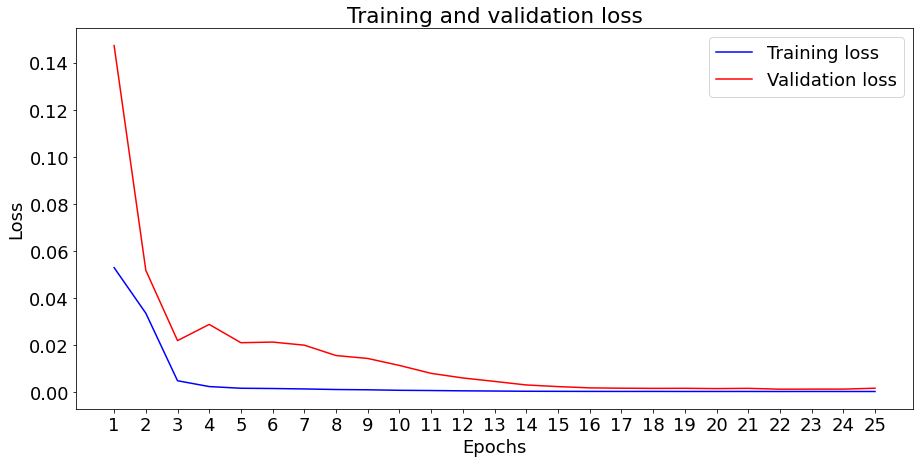

In [81]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
loss_values50 = loss_values[0:150]
val_loss_values50 = val_loss_values[0:150]
epochs = range(1, len(loss_values50) + 1)
plt.plot(epochs, loss_values50, 'b',color = 'blue', label='Training loss')
plt.plot(epochs, val_loss_values50, 'b',color='red', label='Validation loss')
plt.rc('font', size = 18)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)
fig = plt.gcf()
fig.set_size_inches(15,7)
#fig.savefig('img/25/mrftest&validationlossconv1dlstm.png', dpi=300)
plt.show()

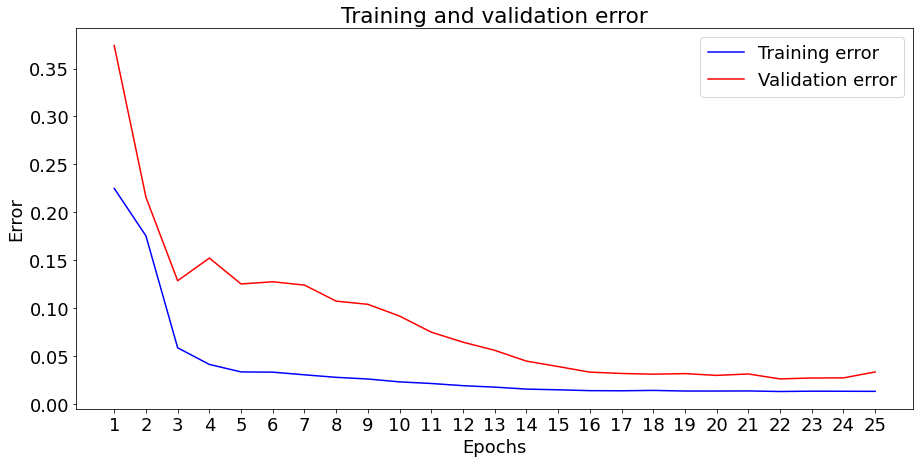

In [82]:
mae = history_dict['mae']
vmae = history_dict['val_mae']
epochs = range(1, len(mae) + 1)
plt.plot(epochs, mae, 'b',color = 'blue', label='Training error')
plt.plot(epochs, vmae, 'b',color='red', label='Validation error')
plt.title('Training and validation error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.xticks(epochs)
fig = plt.gcf()
fig.set_size_inches(15,7)
#fig.savefig('img/25/mrftest&validationerrorconv1dlstm.png', dpi=300)
plt.show()

In [83]:
model.metrics_names

['loss', 'mae']

In [84]:
trainScore = model.evaluate(x_train, y_train, verbose=0)
testScore = model.evaluate(x_test, y_test, verbose=0)

학습된 모델을 test셋에 적용시켜 예측, 시각화

In [85]:
#predicting values for y_test
p = model.predict(x_test)

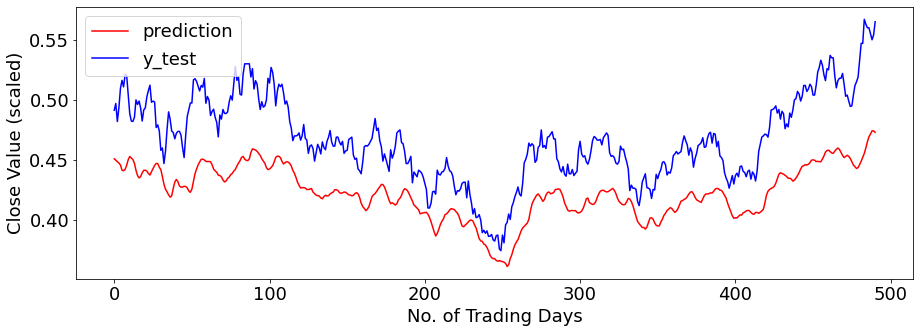

In [86]:
plt.plot(p,color='red', label='prediction')
plt.plot(y_test,color='blue', label='y_test')
plt.xlabel('No. of Trading Days')
plt.ylabel('Close Value (scaled)')
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(15, 5)
#fig.savefig('img/25/mrftestconv1dlstm.png', dpi=300)
plt.show()

In [87]:
p1= model.predict(x_train)

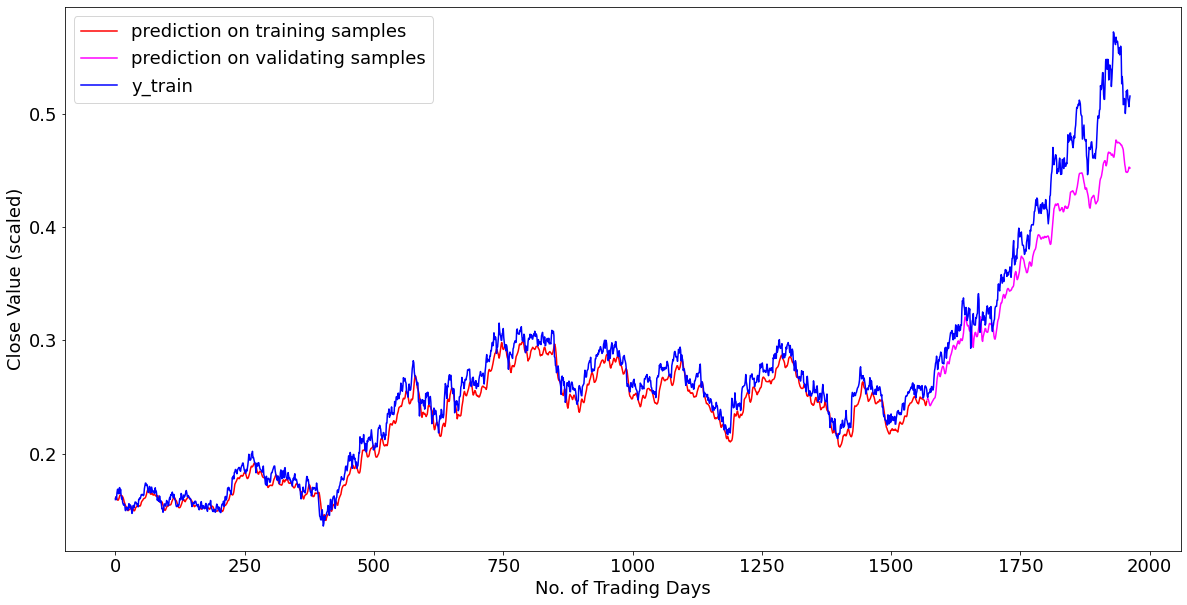

In [88]:

plt.plot(p1[:1570],color='red', label='prediction on training samples')
x = np.array(range(1570,1963))
plt.plot(x,p1[1570:],color = 'magenta',label ='prediction on validating samples')
plt.plot(y_train,color='blue', label='y_train')
plt.xlabel('No. of Trading Days')
plt.ylabel('Close Value (scaled)')
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(20,10)
#fig.savefig('img/25/mrftrainconv1dlstm.png', dpi=300)
plt.show()

## 3. Result

Trainset만큼 일치하지는 않지만,

validation set과 testset의 추세가 실제 데이터와 흡사한 추세를 지님

In [99]:
y = y_test * 10000
y_pred = p.reshape(491)
y_pred = y_pred * 10000

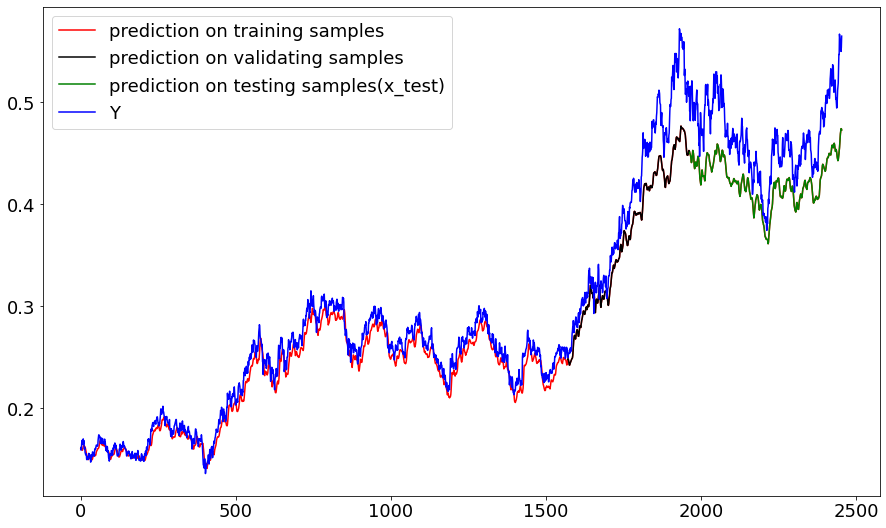

In [100]:
Y = np.concatenate((y_train,y_test),axis = 0)
P = np.concatenate((p1,p),axis = 0)
#plotting the complete Y set with predicted values on x_train and x_test(variable p1 & p respectively given above)
#for 
plt.plot(P[:],color='red', label='prediction on training samples')
#for validating samples
z = np.array(range(1570,1963))
plt.plot(z,P[1570:1963],color = 'black',label ='prediction on validating samples')
#for testing samples
x = np.array(range(1963,2454))
plt.plot(x,P[1963:],color = 'green',label ='prediction on testing samples(x_test)')

plt.plot(Y,color='blue', label='Y')
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(15,9)
plt.show()